In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
np.random.seed(123)

In [3]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [4]:
def calculate_people_ages(N,res):
    age_people = []
    for i in range(N):
        age_people.append(res[i] + res[i+N] + res[i+2*N])
    return age_people

In [5]:
def calculate_people_ages_2strains(N,res):
    age_people = []
    for i in range(N):
        age_people.append(res[i] + res[i+N] + res[i+2*N] + res[i+3*N] + res[i+4*N] + res[i+5*N] + res[i+6*N] + res[i+7*N])
    return age_people

In [6]:
def modify_initial_condition(y0, prop_imported):
    y0_aux = y0.copy()
    y0[:N] = y0_aux[:N] - y0_aux[:N]*prop_imported
    y0[N:2*N] = y0_aux[N:2*N] + y0_aux[:N]*prop_imported
    return y0

In [8]:
def modify_initial_condition_2strains(y0, prop_imported, season):
    y0_aux = y0.copy()
    y0[:N] = y0_aux[:N] - y0_aux[:N]*prop_imported
    if(season < 5):
        y0[3*N:4*N] = y0_aux[N:2*N] + y0_aux[:N]*(prop_imported)
    else:
        y0[3*N:4*N] = y0_aux[3*N:4*N] + y0_aux[:N]*(prop_imported/2)
        y0[4*N:5*N] = y0_aux[3*N:4*N] + y0_aux[:N]*(prop_imported/2)
    return y0

In [9]:
def modify_initial_condition_2(y0):
    y0_aux = y0.copy()
    y0[:N] = y0_aux[:N] - 1
    y0[N:2*N] = y0_aux[N:2*N] + 1
    return y0

In [10]:
def n_groups_model(y, t, N, pop, nu, beta, gamma, mu_vec, l_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT/pop - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT/pop - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    return np.array([dSdt, dIdt, dRdt]).flatten()

In [11]:
def n_groups_seasonal_model(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT/pop - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2]
    dIdt =  beta*S[1:-1]*IT/pop - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    return np.array([dSdt, dIdt, dRdt]).flatten()

## Checking with two groups case

In [12]:
N = 2
pop = 1

alpha = 0.25
beta = 3*(1/7.0) 
mu_0 = 0.0
gamma = 1/(7.0)
l_0 = 1/(1*365)
nu = (l_0 + mu_0)*(alpha)
mu_1 = (l_0*(alpha))/(1-alpha)

y0 = alpha, 1-alpha-0.1, 0.0, 0.1, 0.0, 0.0
t_total = np.linspace(0, 365*20, 365*20)

mu_vec = np.array([mu_0,mu_1])
l_vec = np.array([l_0,0])

ret = odeint(n_groups_model, y0, t_total, args=(N, pop, nu, beta, gamma, mu_vec, l_vec))

In [16]:
y0

(0.25, 0.65, 0.0, 0.1, 0.0, 0.0)

In [15]:
ret.shape

(7300, 6)

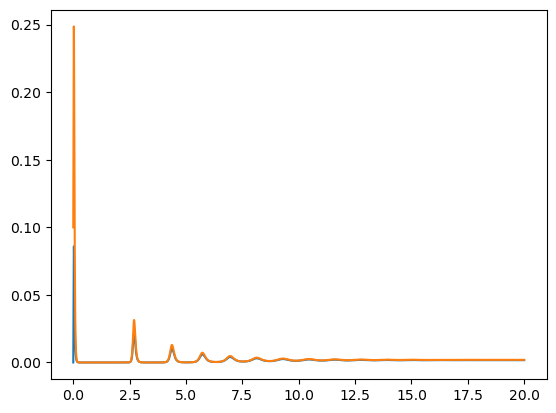

In [13]:
plt.plot(t_total/365,ret[:,2:4])

## Example with Sao Paulo Real Data - non seasonal

In [12]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7
beta = 10*(1./7)
mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

y0 = np.array([S0, I0, R0]).flatten()

seasons = 20
t_total = np.arange(0,365*seasons,1)

In [13]:
pop

11852909.661244685

In [14]:
ret = odeint(n_groups_model, y0, t_total, args=(N, pop, nu, beta, gamma, mu_vec, l_vec))

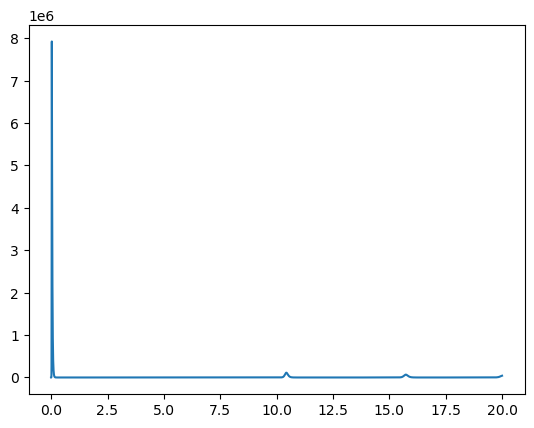

In [15]:
plt.plot(t_total/365,ret[:,N:2*N].sum(axis=1))
plt.show()

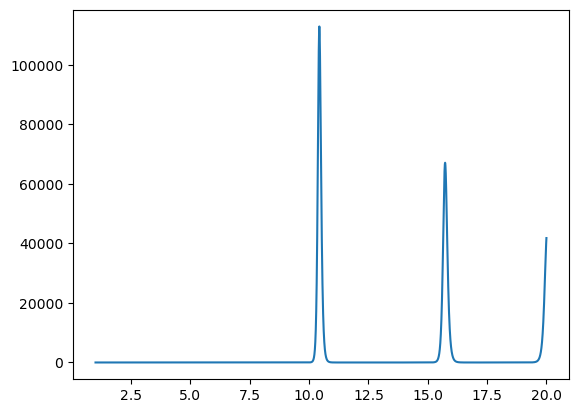

In [16]:
plt.plot(t_total[365:]/365,ret[365:,N:2*N].sum(axis=1))
plt.show()

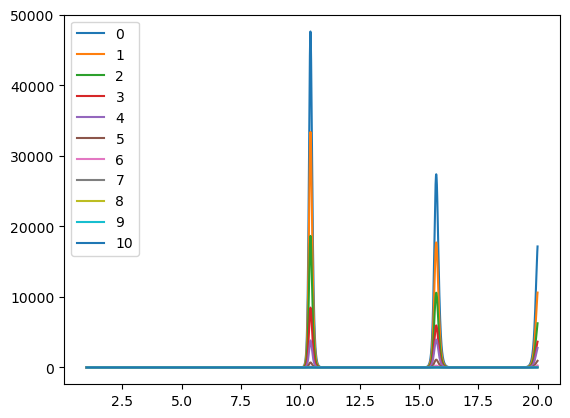

In [17]:
for i in range(11):
    plt.plot(t_total[365:]/365,ret[365:,N+i], label = i)
plt.legend()
plt.show()

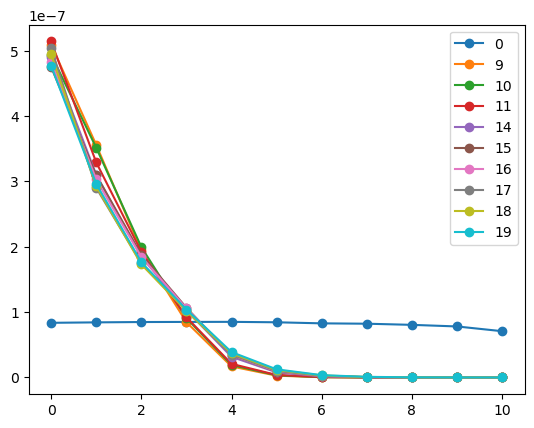

In [18]:
for season in range(seasons):
    infected_season = ret[season*365:(season+1)*365,N:2*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages(N,ret[(season+1)*365 - 1,:]) # people per age group
    age_people_infected = ret[season*365:(season+1)*365,:].sum(axis = 0)[N:2*N]
    age = np.arange(N)
    if infected_season >= 1:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = season)
plt.legend()
plt.show()

## Example with Sao Paulo Real Data - seasonal

In [19]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 1.5*(1/7.0) 
beta_aug = 10*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

y0 = np.array([S0, I0, R0]).flatten()

seasons = 30
t_total = np.arange(0,365*seasons,1)

In [20]:
ret = odeint(n_groups_seasonal_model, y0, t_total, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))

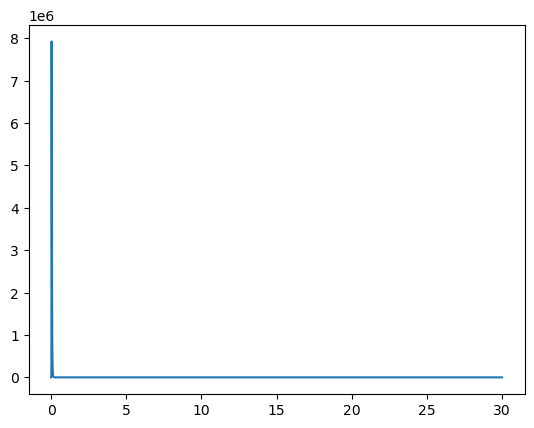

In [21]:
plt.plot(t_total/365,ret[:,N:2*N].sum(axis=1))
plt.show()

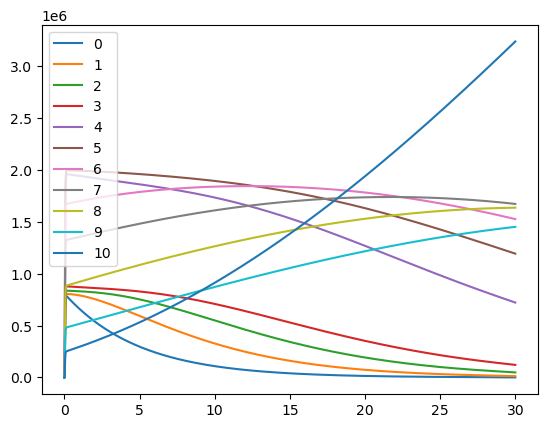

In [22]:
plt.plot(t_total/365,ret[:,2*N:(3*N)],label=np.arange(11))
plt.legend()
plt.show()

## Example with Sao Paulo Real Data - seasonal + deterministic reintroductions 

In [10]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    infected_season = ret[0:(1)*365,N:2*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages(N,ret[(1)*365 - 1,:]) # people per age group
    age_people_infected = ret[0:(1)*365,:].sum(axis = 0)[N:2*N]
    age = np.arange(N)
    if infected_season >= 1:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = season)
plt.legend()

NameError: name 'n_groups_seasonal_model' is not defined

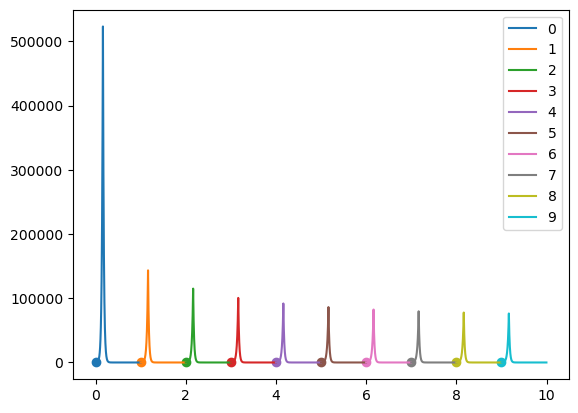

In [24]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1), label = season)
    plt.scatter((season*365)/365,y0[N:2*N].sum())
plt.legend()

## Example with Sao Paulo Real Data - seasonal + deterministic introductions +  year transmission

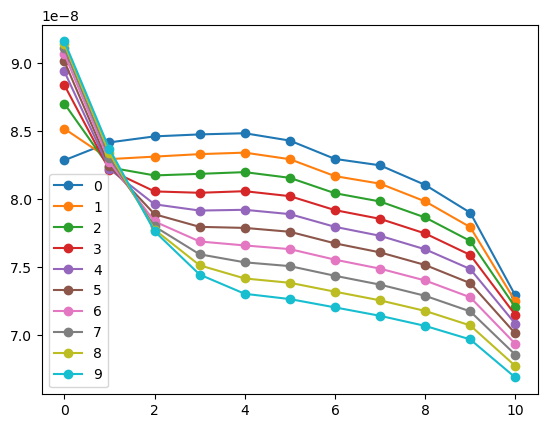

In [25]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0.8*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    infected_season = ret[0:(1)*365,N:2*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages(N,ret[(1)*365 - 1,:]) # people per age group
    age_people_infected = ret[0:(1)*365,:].sum(axis = 0)[N:2*N]
    age = np.arange(N)
    if infected_season >= 1:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = season)
plt.legend()

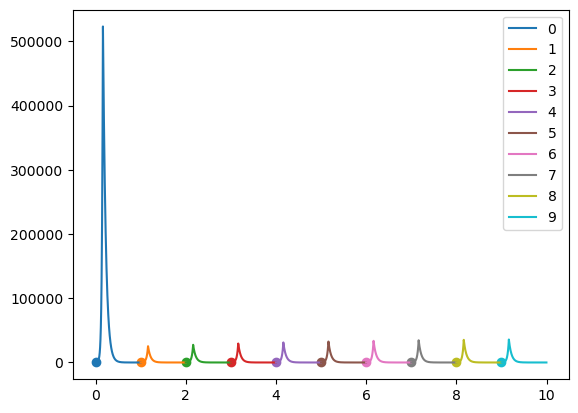

In [26]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0.8*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition(y0,prop_imported)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1), label = season)
    plt.scatter((season*365)/365,y0[N:2*N].sum())
plt.legend()

## Example with Sao Paulo Real Data - seasonal + stochastic reintroductions 

### Modified here for the coloquinho

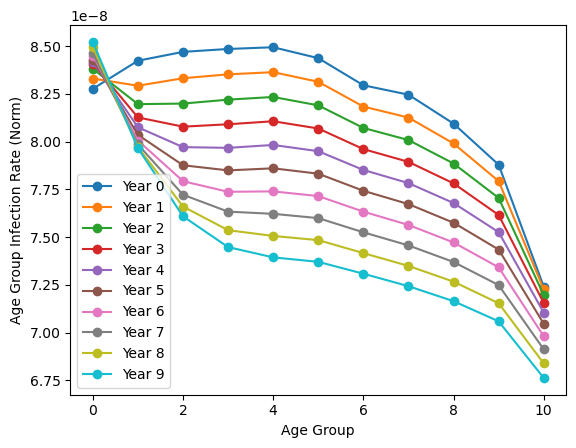

In [24]:
np.random.seed(123)
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0.0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    prop_imported = 0.00001*np.random.uniform(0,1)
    y0 = modify_initial_condition(y0,prop_imported)
    infected_season = ret[0:(1)*365,N:2*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages(N,ret[(1)*365 - 1,:]) # people per age group
    age_people_infected = ret[0:(1)*365,:].sum(axis = 0)[N:2*N]
    age = np.arange(N)
    if infected_season >= 1:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = 'Year '+str(season))
plt.xlabel('Age Group')
plt.ylabel('Age Group Infection Rate (Norm)')
plt.legend()
plt.show()

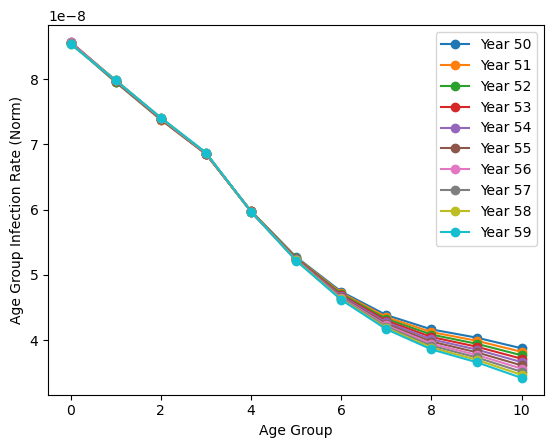

In [25]:
np.random.seed(123)
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0.0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 60
prop_imported = 0.001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    prop_imported = 0.00001*np.random.uniform(0,1)
    y0 = modify_initial_condition(y0,prop_imported)
    infected_season = ret[0:(1)*365,N:2*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages(N,ret[(1)*365 - 1,:]) # people per age group
    age_people_infected = ret[0:(1)*365,:].sum(axis = 0)[N:2*N]
    age = np.arange(N)
    if infected_season >= 1 and season >= 50:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = 'Year '+str(season))
plt.xlabel('Age Group')
plt.ylabel('Age Group Infection Rate (Norm)')
plt.legend()
plt.show()

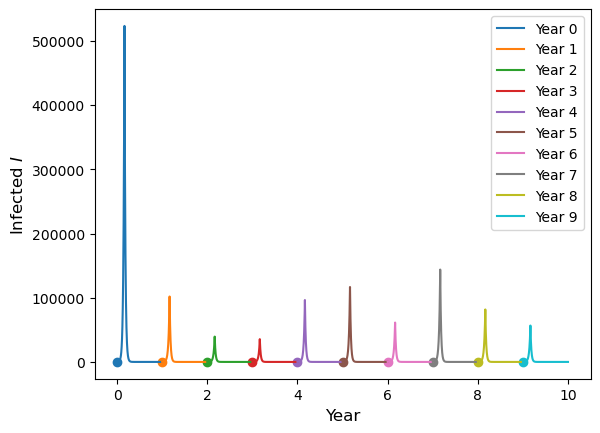

In [21]:
np.random.seed(123)
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I0 = np.zeros(N) 
I0 = 0.00001*S0
R0 = np.zeros(N)
pop = S0.sum() + I0.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7


beta_0 = 0.0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 10
prop_imported = 0.001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, I0, R0]).flatten()
for season in np.arange(seasons):
    ret = odeint(n_groups_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    prop_imported = 0.00001*np.random.uniform(0,1)
    y0 = modify_initial_condition(y0,prop_imported)
    plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1), label = 'Year '+str(season))
    plt.scatter((season*365)/365,y0[N:2*N].sum())
plt.xlabel(r'Year', fontsize = 12)
plt.ylabel(r'Infected $I$',fontsize = 12)
plt.legend()

## Including cross-immunity and several strains

In [29]:
def n_groups_2_strain_seasonal_model(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, sigma, mu_vec, l_vec):
    # N is number of age groups 
    # s is number of strains 
    # S, S1, S2, I1, I2, I12, I21, R
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    S = y[0:N]
    S1 = y[N:2*N]
    S2 = y[2*N:3*N]
    I1 = y[3*N:4*N] 
    I2 = y[4*N:5*N]
    I12 = y[5*N:6*N]
    I21 = y[6*N:7*N]
    R = y[7*N:]
    I1T = sum(I1) + sum(I12) # total infected with 1
    I2T = sum(I2) + sum(I21) # total infected with 2
    S = np.append(S,0)
    S1 = np.append(S1,0)
    S2 = np.append(S2,0)
    I1 = np.append(I1,0)
    I2 = np.append(I2,0)
    I12 = np.append(I12,0)
    I21 = np.append(I21,0)
    R = np.append(R,0)
    S = np.append(0,S)
    S1 = np.append(0,S1)
    S2 = np.append(0,S2)
    I1 = np.append(0,I1)
    I2 = np.append(0,I2)
    I12 = np.append(0,I12)
    I21 = np.append(0,I21)
    R = np.append(0,R)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*I1T/pop - beta*S[1:-1]*I2T/pop - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2] #susceptibles
    dS1dt = - beta*sigma*S1[1:-1]*I1T/pop - mu_vec*S1[1:-1] - l_vec*S1[1:-1] + l_vec_2*S1[:-2] + gamma*I2[1:-1] #susceptibles to 1
    dS2dt = - beta*sigma*S2[1:-1]*I2T/pop - mu_vec*S2[1:-1] - l_vec*S2[1:-1] + l_vec_2*S2[:-2] + gamma*I1[1:-1] #susceptibles to 2
    dI1dt =  beta*S[1:-1]*I1T/pop - gamma*I1[1:-1] - mu_vec*I1[1:-1] - l_vec*I1[1:-1] + l_vec_2*I1[:-2] # infected for 1st time with 1
    dI2dt =  beta*S[1:-1]*I2T/pop - gamma*I2[1:-1] - mu_vec*I2[1:-1] - l_vec*I2[1:-1] + l_vec_2*I2[:-2] # infected for 1st time with 2
    dI12dt = beta*sigma*S1[1:-1]*I1T/pop - gamma*I12[1:-1] - mu_vec*I12[1:-1] - l_vec*I12[1:-1] + l_vec_2*I12[:-2] # infected with 1 immune to 2
    dI21dt = beta*sigma*S2[1:-1]*I2T/pop - gamma*I21[1:-1] - mu_vec*I21[1:-1] - l_vec*I21[1:-1] + l_vec_2*I21[:-2] # infected with 2 immune to 1
    dRdt =  gamma*I12[1:-1] + gamma*I21[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2]
    dSdt[0] = dSdt[0] + nu
    return np.array([dSdt, dS1dt, dS2dt, dI1dt, dI2dt, dI12dt, dI21dt, dRdt]).flatten()

## Example with Sao Paulo Real Data - seasonal + deterministic reintroductions - positive sigma (cross-immunity prevents infection) 

In [30]:
def calculate_infected_ages_2strains(N, ret):
    res = []
    for i in range(N):
        res.append(ret[i] + ret[i + N - 1] + ret[i + 2*N - 1] + ret[i + 3*N - 1])
    return np.array(res)

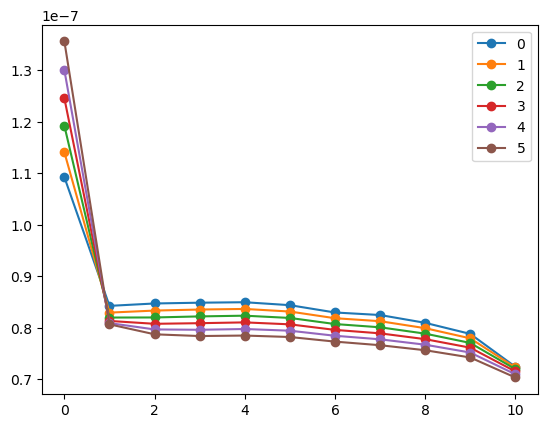

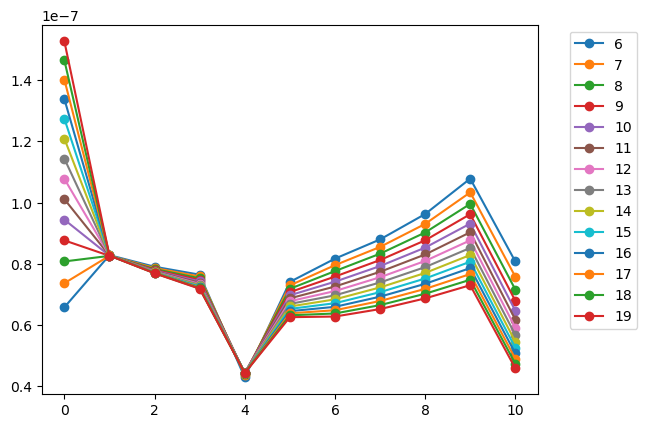

In [31]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I10 = np.zeros(N) 
I10 = 0.00001*S0
R0 = np.zeros(N)
I20 = I120 = I210 = S10 = S20 = np.zeros(N)

pop = S0.sum() + I10.sum() + I20.sum() + S10.sum() + S20.sum() + I120.sum() + I210.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7
sigma = 0.5

beta_0 = 0.0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 20
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, S10, S20, I10, I20, I120, I210, R0]).flatten()


for season in np.arange(seasons):
    ret = odeint(n_groups_2_strain_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, sigma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_2strains(y0, prop_imported, season)
    infected_season = ret[0:(1)*365,3*N:7*N].sum()
    infected_season = max(infected_season,0) # total infected in the season
    age_people = calculate_people_ages_2strains(N,ret[(1)*365 - 1,:]) # people per age group
    age_people_infected = calculate_infected_ages_2strains(N, ret[0:(1)*365,3*N:7*N].sum(axis=0))
    age = np.arange(N)
    if infected_season >= 1:
        plt.plot(age,age_people_infected/(np.array(age_people)*infected_season),'-o',label = season)
    if (season) == 5:
        plt.legend()
        plt.show()
plt.legend(bbox_to_anchor=(1.05, 1.0))

In [32]:
N = 11

S0 = np.array([ 793061.06666667,  803773.6       ,  836496.06666667,
        877970.73333333, 1960304.2       , 1995084.66666667,
       1666076.86666667, 1319655.46666667,  878162.4       ,
        476538.4       ,  245667.66666667])

I10 = np.zeros(N) 
I10 = 0.00001*S0
R0 = np.zeros(N)
I20 = I120 = I210 = S10 = S20 = np.zeros(N)

pop = S0.sum() + I10.sum() + I20.sum() + S10.sum() + S20.sum() + I120.sum() + I210.sum() + R0.sum()


nu = 473.8947696139477
gamma = 1./7
sigma = 0.01

beta_0 = 0*(1/7.0) 
beta_aug = 2.0*(1/7.0) # run with 5 as well
t_start = 0
t_season = 60
t_year = 365


mu_vec = np.array([6.78019925,  0.46102117,  0.61519303,  2.69464508,  7.49638854,
        9.33038605, 15.32739726, 24.91195517, 33.90124533, 41.52988792,
       57.66575342])/(pop)
l_vec =  1/(365*np.array([5,5,5,5,10,10,10,10,10,10,20]))
l_vec[-1] = 0

seasons = 20
prop_imported = 0.00001
t_total = np.arange(0,365*seasons,1)
t_season_single = np.arange(0,365,1)

y0 = np.array([S0, S10, S20, I10, I20, I120, I210, R0]).flatten()


inf_1 = np.array([])
inf_2 = np.array([])
initial_cond = np.array([])

for season in np.arange(seasons):
    initial_cond = np.append(initial_cond,y0[3*11:7*11].sum())
    ret = odeint(n_groups_2_strain_seasonal_model, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, sigma, mu_vec, l_vec))
    y0 = ret[-1,:].copy()
    y0 = modify_initial_condition_2strains(y0, prop_imported, season)
    inf_1 = np.append(inf_1,(ret[0:365,3*11:4*11] + ret[0:365,5*11:6*11]).sum(axis=1)) 
    inf_2 = np.append(inf_2,(ret[0:365,4*11:5*11] + ret[0:365,6*11:7*11]).sum(axis=1))

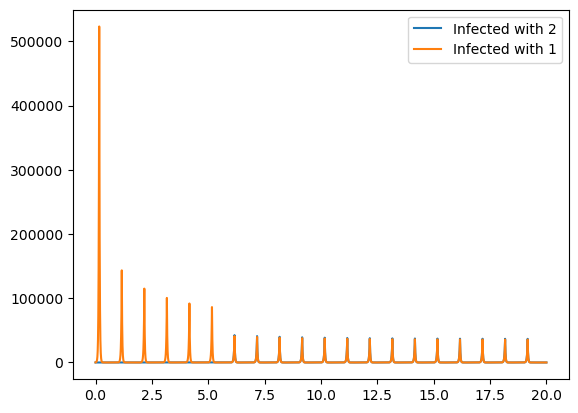

In [33]:
plt.plot(t_total/365,inf_2, label = 'Infected with 2')
plt.plot(t_total/365,inf_1, label = 'Infected with 1')
plt.legend()
plt.show()

(2.0, 5.0)

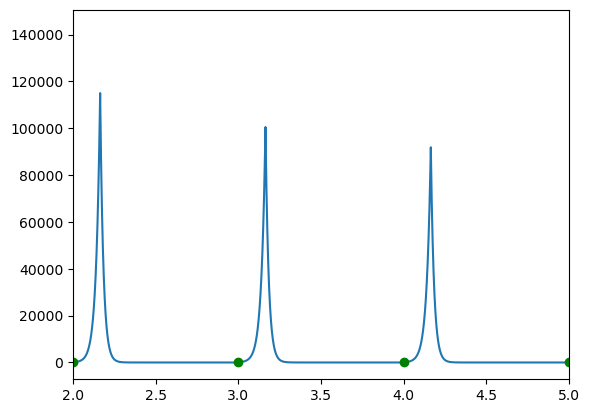

In [39]:
plt.plot(t_total[365:]/365,inf_1[365:]+inf_2[365:])
plt.plot(np.arange(seasons)[1:],initial_cond[1:],'o', color = 'green')
plt.xlim((2,5))